In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 828)
(734160, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:56 - loss: 0.2014 - STD: 1.7568e-04 - MAE: 0.4368

 4/74 [>.............................] - ETA: 2s - loss: 0.0713 - STD: 4.5776e-04 - MAE: 0.2052  

 5/74 [=>............................] - ETA: 2s - loss: 0.0629 - STD: 4.1119e-04 - MAE: 0.1906

 6/74 [=>............................] - ETA: 3s - loss: 0.0583 - STD: 3.6539e-04 - MAE: 0.1844

 7/74 [=>............................] - ETA: 3s - loss: 0.0553 - STD: 3.2535e-04 - MAE: 0.1812

 8/74 [==>...........................] - ETA: 3s - loss: 0.0531 - STD: 2.9192e-04 - MAE: 0.1791

 9/74 [==>...........................] - ETA: 3s - loss: 0.0515 - STD: 2.6466e-04 - MAE: 0.1775

10/74 [===>..........................] - ETA: 3s - loss: 0.0502 - STD: 2.4288e-04 - MAE: 0.1759

11/74 [===>..........................] - ETA: 3s - loss: 0.0487 - STD: 2.2573e-04 - MAE: 0.1737

12/74 [===>..........................] - ETA: 3s - loss: 0.0474 - STD: 2.1252e-04 - MAE: 0.1711

13/74 [====>.........................] - ETA: 3s - loss: 0.0459 - STD: 2.0255e-04 - MAE: 0.1679

14/74 [====>.........................] - ETA: 3s - loss: 0.0443 - STD: 1.9508e-04 - MAE: 0.1638

15/74 [=====>........................] - ETA: 3s - loss: 0.0428 - STD: 1.8959e-04 - MAE: 0.1593

16/74 [=====>........................] - ETA: 3s - loss: 0.0412 - STD: 1.8560e-04 - MAE: 0.1541

17/74 [=====>........................] - ETA: 3s - loss: 0.0396 - STD: 1.8234e-04 - MAE: 0.1486

18/74 [======>.......................] - ETA: 3s - loss: 0.0381 - STD: 1.7970e-04 - MAE: 0.1439

19/74 [======>.......................] - ETA: 3s - loss: 0.0367 - STD: 1.7724e-04 - MAE: 0.1403

20/74 [=======>......................] - ETA: 3s - loss: 0.0355 - STD: 1.7489e-04 - MAE: 0.1379

21/74 [=======>......................] - ETA: 3s - loss: 0.0345 - STD: 1.7244e-04 - MAE: 0.1364

22/74 [=======>......................] - ETA: 3s - loss: 0.0338 - STD: 1.7008e-04 - MAE: 0.1355

23/74 [========>.....................] - ETA: 3s - loss: 0.0331 - STD: 1.6761e-04 - MAE: 0.1348

24/74 [========>.....................] - ETA: 3s - loss: 0.0324 - STD: 1.6516e-04 - MAE: 0.1341

25/74 [=========>....................] - ETA: 3s - loss: 0.0318 - STD: 1.6278e-04 - MAE: 0.1331

26/74 [=========>....................] - ETA: 3s - loss: 0.0311 - STD: 1.6040e-04 - MAE: 0.1319

27/74 [=========>....................] - ETA: 2s - loss: 0.0305 - STD: 1.5808e-04 - MAE: 0.1305

28/74 [==========>...................] - ETA: 2s - loss: 0.0298 - STD: 1.5581e-04 - MAE: 0.1288

29/74 [==========>...................] - ETA: 2s - loss: 0.0292 - STD: 1.5359e-04 - MAE: 0.1269

30/74 [===========>..................] - ETA: 2s - loss: 0.0287 - STD: 1.5147e-04 - MAE: 0.1249

31/74 [===========>..................] - ETA: 2s - loss: 0.0281 - STD: 1.4938e-04 - MAE: 0.1229

32/74 [===========>..................] - ETA: 2s - loss: 0.0276 - STD: 1.4737e-04 - MAE: 0.1209

33/74 [============>.................] - ETA: 2s - loss: 0.0272 - STD: 1.4547e-04 - MAE: 0.1190

34/74 [============>.................] - ETA: 2s - loss: 0.0268 - STD: 1.4368e-04 - MAE: 0.1173

35/74 [=============>................] - ETA: 2s - loss: 0.0264 - STD: 1.4198e-04 - MAE: 0.1157

36/74 [=============>................] - ETA: 2s - loss: 0.0260 - STD: 1.4044e-04 - MAE: 0.1141

37/74 [==============>...............] - ETA: 2s - loss: 0.0257 - STD: 1.3907e-04 - MAE: 0.1127

38/74 [==============>...............] - ETA: 2s - loss: 0.0254 - STD: 1.3786e-04 - MAE: 0.1113

39/74 [==============>...............] - ETA: 2s - loss: 0.0251 - STD: 1.3680e-04 - MAE: 0.1101

40/74 [===============>..............] - ETA: 2s - loss: 0.0247 - STD: 1.3588e-04 - MAE: 0.1088

41/74 [===============>..............] - ETA: 2s - loss: 0.0244 - STD: 1.3512e-04 - MAE: 0.1078

42/74 [================>.............] - ETA: 2s - loss: 0.0241 - STD: 1.3451e-04 - MAE: 0.1068

43/74 [================>.............] - ETA: 2s - loss: 0.0239 - STD: 1.3402e-04 - MAE: 0.1060

44/74 [================>.............] - ETA: 1s - loss: 0.0236 - STD: 1.3364e-04 - MAE: 0.1053

45/74 [=================>............] - ETA: 1s - loss: 0.0233 - STD: 1.3335e-04 - MAE: 0.1047

46/74 [=================>............] - ETA: 1s - loss: 0.0231 - STD: 1.3317e-04 - MAE: 0.1042

47/74 [==================>...........] - ETA: 1s - loss: 0.0229 - STD: 1.3306e-04 - MAE: 0.1038

48/74 [==================>...........] - ETA: 1s - loss: 0.0226 - STD: 1.3300e-04 - MAE: 0.1033

49/74 [==================>...........] - ETA: 1s - loss: 0.0224 - STD: 1.3300e-04 - MAE: 0.1028

50/74 [===================>..........] - ETA: 1s - loss: 0.0222 - STD: 1.3305e-04 - MAE: 0.1023

51/74 [===================>..........] - ETA: 1s - loss: 0.0220 - STD: 1.3317e-04 - MAE: 0.1018

52/74 [====================>.........] - ETA: 1s - loss: 0.0219 - STD: 1.3328e-04 - MAE: 0.1012

55/74 [=====================>........] - ETA: 1s - loss: 0.0214 - STD: 1.3391e-04 - MAE: 0.0993

57/74 [======================>.......] - ETA: 1s - loss: 0.0211 - STD: 1.3455e-04 - MAE: 0.0981

58/74 [======================>.......] - ETA: 1s - loss: 0.0209 - STD: 1.3495e-04 - MAE: 0.0975

59/74 [======================>.......] - ETA: 1s - loss: 0.0208 - STD: 1.3545e-04 - MAE: 0.0970

60/74 [=======================>......] - ETA: 1s - loss: 0.0206 - STD: 1.3601e-04 - MAE: 0.0964

61/74 [=======================>......] - ETA: 0s - loss: 0.0205 - STD: 1.3664e-04 - MAE: 0.0959

62/74 [========================>.....] - ETA: 0s - loss: 0.0204 - STD: 1.3736e-04 - MAE: 0.0954

63/74 [========================>.....] - ETA: 0s - loss: 0.0202 - STD: 1.3816e-04 - MAE: 0.0950

64/74 [========================>.....] - ETA: 0s - loss: 0.0201 - STD: 1.3902e-04 - MAE: 0.0946

65/74 [=========================>....] - ETA: 0s - loss: 0.0200 - STD: 1.4000e-04 - MAE: 0.0942

66/74 [=========================>....] - ETA: 0s - loss: 0.0198 - STD: 1.4105e-04 - MAE: 0.0939

67/74 [==========================>...] - ETA: 0s - loss: 0.0197 - STD: 1.4217e-04 - MAE: 0.0935

68/74 [==========================>...] - ETA: 0s - loss: 0.0196 - STD: 1.4338e-04 - MAE: 0.0932

69/74 [==========================>...] - ETA: 0s - loss: 0.0195 - STD: 1.4464e-04 - MAE: 0.0929

70/74 [===========================>..] - ETA: 0s - loss: 0.0194 - STD: 1.4598e-04 - MAE: 0.0926

71/74 [===========================>..] - ETA: 0s - loss: 0.0193 - STD: 1.4744e-04 - MAE: 0.0924

72/74 [============================>.] - ETA: 0s - loss: 0.0192 - STD: 1.4894e-04 - MAE: 0.0921

73/74 [============================>.] - ETA: 0s - loss: 0.0191 - STD: 1.5046e-04 - MAE: 0.0918

74/74 [==============================] - ETA: 0s - loss: 0.0190 - STD: 1.5210e-04 - MAE: 0.0915

74/74 [==============================] - 8s 83ms/step - loss: 0.0190 - STD: 1.5210e-04 - MAE: 0.0915 - val_loss: 0.0145 - val_STD: 1.9234e-04 - val_MAE: 0.0733


Epoch 2/10000


 1/74 [..............................] - ETA: 8s - loss: 0.0119 - STD: 2.7916e-04 - MAE: 0.0693

 2/74 [..............................] - ETA: 4s - loss: 0.0120 - STD: 2.8346e-04 - MAE: 0.0691

 3/74 [>.............................] - ETA: 4s - loss: 0.0120 - STD: 2.8751e-04 - MAE: 0.0687

 4/74 [>.............................] - ETA: 4s - loss: 0.0119 - STD: 2.9241e-04 - MAE: 0.0683

 5/74 [=>............................] - ETA: 4s - loss: 0.0120 - STD: 2.9797e-04 - MAE: 0.0684

 6/74 [=>............................] - ETA: 4s - loss: 0.0120 - STD: 3.0300e-04 - MAE: 0.0680

 7/74 [=>............................] - ETA: 4s - loss: 0.0120 - STD: 3.0899e-04 - MAE: 0.0681

 8/74 [==>...........................] - ETA: 4s - loss: 0.0120 - STD: 3.1537e-04 - MAE: 0.0681

 9/74 [==>...........................] - ETA: 4s - loss: 0.0120 - STD: 3.2166e-04 - MAE: 0.0680

10/74 [===>..........................] - ETA: 4s - loss: 0.0120 - STD: 3.2833e-04 - MAE: 0.0682

11/74 [===>..........................] - ETA: 4s - loss: 0.0120 - STD: 3.3538e-04 - MAE: 0.0683

12/74 [===>..........................] - ETA: 4s - loss: 0.0120 - STD: 3.4264e-04 - MAE: 0.0685

13/74 [====>.........................] - ETA: 4s - loss: 0.0120 - STD: 3.4984e-04 - MAE: 0.0685

14/74 [====>.........................] - ETA: 3s - loss: 0.0120 - STD: 3.5771e-04 - MAE: 0.0687

15/74 [=====>........................] - ETA: 3s - loss: 0.0120 - STD: 3.6570e-04 - MAE: 0.0689

16/74 [=====>........................] - ETA: 3s - loss: 0.0120 - STD: 3.7385e-04 - MAE: 0.0689

17/74 [=====>........................] - ETA: 3s - loss: 0.0120 - STD: 3.8245e-04 - MAE: 0.0690

18/74 [======>.......................] - ETA: 3s - loss: 0.0120 - STD: 3.9137e-04 - MAE: 0.0691

19/74 [======>.......................] - ETA: 3s - loss: 0.0120 - STD: 4.0064e-04 - MAE: 0.0692

20/74 [=======>......................] - ETA: 3s - loss: 0.0120 - STD: 4.0956e-04 - MAE: 0.0691

21/74 [=======>......................] - ETA: 3s - loss: 0.0120 - STD: 4.1924e-04 - MAE: 0.0691

22/74 [=======>......................] - ETA: 3s - loss: 0.0120 - STD: 4.2898e-04 - MAE: 0.0691

23/74 [========>.....................] - ETA: 3s - loss: 0.0120 - STD: 4.3938e-04 - MAE: 0.0690

24/74 [========>.....................] - ETA: 3s - loss: 0.0120 - STD: 4.5001e-04 - MAE: 0.0690

25/74 [=========>....................] - ETA: 3s - loss: 0.0120 - STD: 4.6075e-04 - MAE: 0.0689

26/74 [=========>....................] - ETA: 3s - loss: 0.0120 - STD: 4.7258e-04 - MAE: 0.0688

27/74 [=========>....................] - ETA: 3s - loss: 0.0119 - STD: 4.8464e-04 - MAE: 0.0688

28/74 [==========>...................] - ETA: 3s - loss: 0.0120 - STD: 4.9743e-04 - MAE: 0.0688

29/74 [==========>...................] - ETA: 2s - loss: 0.0120 - STD: 5.1065e-04 - MAE: 0.0688

30/74 [===========>..................] - ETA: 2s - loss: 0.0120 - STD: 5.2467e-04 - MAE: 0.0687

31/74 [===========>..................] - ETA: 2s - loss: 0.0119 - STD: 5.3919e-04 - MAE: 0.0687

32/74 [===========>..................] - ETA: 2s - loss: 0.0120 - STD: 5.5495e-04 - MAE: 0.0688

33/74 [============>.................] - ETA: 2s - loss: 0.0120 - STD: 5.7101e-04 - MAE: 0.0688

34/74 [============>.................] - ETA: 2s - loss: 0.0119 - STD: 5.8767e-04 - MAE: 0.0688

35/74 [=============>................] - ETA: 2s - loss: 0.0120 - STD: 6.0544e-04 - MAE: 0.0689

36/74 [=============>................] - ETA: 2s - loss: 0.0119 - STD: 6.2418e-04 - MAE: 0.0689

37/74 [==============>...............] - ETA: 2s - loss: 0.0119 - STD: 6.4322e-04 - MAE: 0.0688

38/74 [==============>...............] - ETA: 2s - loss: 0.0119 - STD: 6.6314e-04 - MAE: 0.0688

39/74 [==============>...............] - ETA: 2s - loss: 0.0119 - STD: 6.8445e-04 - MAE: 0.0688

40/74 [===============>..............] - ETA: 2s - loss: 0.0119 - STD: 7.0659e-04 - MAE: 0.0688

42/74 [================>.............] - ETA: 2s - loss: 0.0119 - STD: 7.5429e-04 - MAE: 0.0687

43/74 [================>.............] - ETA: 2s - loss: 0.0119 - STD: 7.7974e-04 - MAE: 0.0687

44/74 [================>.............] - ETA: 1s - loss: 0.0119 - STD: 8.0683e-04 - MAE: 0.0687

45/74 [=================>............] - ETA: 1s - loss: 0.0119 - STD: 8.3611e-04 - MAE: 0.0687

46/74 [=================>............] - ETA: 1s - loss: 0.0119 - STD: 8.6644e-04 - MAE: 0.0686

47/74 [==================>...........] - ETA: 1s - loss: 0.0119 - STD: 8.9874e-04 - MAE: 0.0686

48/74 [==================>...........] - ETA: 1s - loss: 0.0119 - STD: 9.3338e-04 - MAE: 0.0686

49/74 [==================>...........] - ETA: 1s - loss: 0.0119 - STD: 9.6980e-04 - MAE: 0.0686

50/74 [===================>..........] - ETA: 1s - loss: 0.0119 - STD: 0.0010 - MAE: 0.0686    

51/74 [===================>..........] - ETA: 1s - loss: 0.0119 - STD: 0.0010 - MAE: 0.0686

52/74 [====================>.........] - ETA: 1s - loss: 0.0118 - STD: 0.0011 - MAE: 0.0686

53/74 [====================>.........] - ETA: 1s - loss: 0.0118 - STD: 0.0011 - MAE: 0.0686

54/74 [====================>.........] - ETA: 1s - loss: 0.0118 - STD: 0.0012 - MAE: 0.0685

55/74 [=====================>........] - ETA: 1s - loss: 0.0118 - STD: 0.0012 - MAE: 0.0685

56/74 [=====================>........] - ETA: 1s - loss: 0.0118 - STD: 0.0013 - MAE: 0.0685

57/74 [======================>.......] - ETA: 1s - loss: 0.0118 - STD: 0.0014 - MAE: 0.0685

58/74 [======================>.......] - ETA: 1s - loss: 0.0118 - STD: 0.0014 - MAE: 0.0684

59/74 [======================>.......] - ETA: 0s - loss: 0.0118 - STD: 0.0015 - MAE: 0.0684

60/74 [=======================>......] - ETA: 0s - loss: 0.0118 - STD: 0.0015 - MAE: 0.0684

61/74 [=======================>......] - ETA: 0s - loss: 0.0118 - STD: 0.0016 - MAE: 0.0683

62/74 [========================>.....] - ETA: 0s - loss: 0.0117 - STD: 0.0017 - MAE: 0.0683

63/74 [========================>.....] - ETA: 0s - loss: 0.0117 - STD: 0.0018 - MAE: 0.0682

64/74 [========================>.....] - ETA: 0s - loss: 0.0117 - STD: 0.0019 - MAE: 0.0682

65/74 [=========================>....] - ETA: 0s - loss: 0.0117 - STD: 0.0020 - MAE: 0.0681

66/74 [=========================>....] - ETA: 0s - loss: 0.0117 - STD: 0.0021 - MAE: 0.0681

67/74 [==========================>...] - ETA: 0s - loss: 0.0117 - STD: 0.0022 - MAE: 0.0680

68/74 [==========================>...] - ETA: 0s - loss: 0.0116 - STD: 0.0023 - MAE: 0.0679

69/74 [==========================>...] - ETA: 0s - loss: 0.0116 - STD: 0.0024 - MAE: 0.0679

70/74 [===========================>..] - ETA: 0s - loss: 0.0116 - STD: 0.0026 - MAE: 0.0678

71/74 [===========================>..] - ETA: 0s - loss: 0.0116 - STD: 0.0027 - MAE: 0.0677

72/74 [============================>.] - ETA: 0s - loss: 0.0116 - STD: 0.0028 - MAE: 0.0677

73/74 [============================>.] - ETA: 0s - loss: 0.0115 - STD: 0.0030 - MAE: 0.0676

74/74 [==============================] - ETA: 0s - loss: 0.0115 - STD: 0.0032 - MAE: 0.0675

74/74 [==============================] - 5s 69ms/step - loss: 0.0115 - STD: 0.0032 - MAE: 0.0675 - val_loss: 0.0116 - val_STD: 0.0114 - val_MAE: 0.0644


Epoch 3/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0097 - STD: 0.0170 - MAE: 0.0617

 2/74 [..............................] - ETA: 5s - loss: 0.0095 - STD: 0.0176 - MAE: 0.0610

 3/74 [>.............................] - ETA: 4s - loss: 0.0094 - STD: 0.0182 - MAE: 0.0607

 4/74 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 0.0188 - MAE: 0.0601

 5/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 0.0196 - MAE: 0.0598

 6/74 [=>............................] - ETA: 4s - loss: 0.0091 - STD: 0.0203 - MAE: 0.0594

 7/74 [=>............................] - ETA: 4s - loss: 0.0090 - STD: 0.0211 - MAE: 0.0591

 8/74 [==>...........................] - ETA: 4s - loss: 0.0089 - STD: 0.0218 - MAE: 0.0586

 9/74 [==>...........................] - ETA: 4s - loss: 0.0087 - STD: 0.0226 - MAE: 0.0581

10/74 [===>..........................] - ETA: 4s - loss: 0.0086 - STD: 0.0234 - MAE: 0.0576

11/74 [===>..........................] - ETA: 4s - loss: 0.0085 - STD: 0.0243 - MAE: 0.0573

12/74 [===>..........................] - ETA: 4s - loss: 0.0084 - STD: 0.0252 - MAE: 0.0569

13/74 [====>.........................] - ETA: 4s - loss: 0.0083 - STD: 0.0261 - MAE: 0.0565

14/74 [====>.........................] - ETA: 4s - loss: 0.0082 - STD: 0.0271 - MAE: 0.0562

15/74 [=====>........................] - ETA: 3s - loss: 0.0081 - STD: 0.0280 - MAE: 0.0558

16/74 [=====>........................] - ETA: 3s - loss: 0.0080 - STD: 0.0290 - MAE: 0.0554

17/74 [=====>........................] - ETA: 3s - loss: 0.0079 - STD: 0.0300 - MAE: 0.0550

18/74 [======>.......................] - ETA: 3s - loss: 0.0078 - STD: 0.0310 - MAE: 0.0545

19/74 [======>.......................] - ETA: 3s - loss: 0.0077 - STD: 0.0319 - MAE: 0.0540

20/74 [=======>......................] - ETA: 3s - loss: 0.0075 - STD: 0.0329 - MAE: 0.0536

21/74 [=======>......................] - ETA: 3s - loss: 0.0074 - STD: 0.0339 - MAE: 0.0531

22/74 [=======>......................] - ETA: 3s - loss: 0.0073 - STD: 0.0349 - MAE: 0.0526

23/74 [========>.....................] - ETA: 3s - loss: 0.0072 - STD: 0.0359 - MAE: 0.0522

24/74 [========>.....................] - ETA: 3s - loss: 0.0071 - STD: 0.0369 - MAE: 0.0517

25/74 [=========>....................] - ETA: 3s - loss: 0.0070 - STD: 0.0380 - MAE: 0.0514

26/74 [=========>....................] - ETA: 3s - loss: 0.0069 - STD: 0.0391 - MAE: 0.0510

27/74 [=========>....................] - ETA: 3s - loss: 0.0068 - STD: 0.0402 - MAE: 0.0506

28/74 [==========>...................] - ETA: 3s - loss: 0.0067 - STD: 0.0413 - MAE: 0.0502

29/74 [==========>...................] - ETA: 3s - loss: 0.0066 - STD: 0.0423 - MAE: 0.0499

30/74 [===========>..................] - ETA: 2s - loss: 0.0066 - STD: 0.0433 - MAE: 0.0496

31/74 [===========>..................] - ETA: 2s - loss: 0.0065 - STD: 0.0443 - MAE: 0.0492

32/74 [===========>..................] - ETA: 2s - loss: 0.0064 - STD: 0.0453 - MAE: 0.0489

33/74 [============>.................] - ETA: 2s - loss: 0.0063 - STD: 0.0462 - MAE: 0.0485

34/74 [============>.................] - ETA: 2s - loss: 0.0062 - STD: 0.0471 - MAE: 0.0482

35/74 [=============>................] - ETA: 2s - loss: 0.0061 - STD: 0.0480 - MAE: 0.0479

36/74 [=============>................] - ETA: 2s - loss: 0.0061 - STD: 0.0489 - MAE: 0.0476

37/74 [==============>...............] - ETA: 2s - loss: 0.0060 - STD: 0.0498 - MAE: 0.0473

38/74 [==============>...............] - ETA: 2s - loss: 0.0059 - STD: 0.0507 - MAE: 0.0470

39/74 [==============>...............] - ETA: 2s - loss: 0.0058 - STD: 0.0516 - MAE: 0.0468

40/74 [===============>..............] - ETA: 2s - loss: 0.0058 - STD: 0.0524 - MAE: 0.0465

41/74 [===============>..............] - ETA: 2s - loss: 0.0057 - STD: 0.0533 - MAE: 0.0462

42/74 [================>.............] - ETA: 2s - loss: 0.0056 - STD: 0.0541 - MAE: 0.0460

43/74 [================>.............] - ETA: 2s - loss: 0.0056 - STD: 0.0548 - MAE: 0.0457

44/74 [================>.............] - ETA: 2s - loss: 0.0055 - STD: 0.0555 - MAE: 0.0455

45/74 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0562 - MAE: 0.0452

46/74 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0568 - MAE: 0.0450

47/74 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0575 - MAE: 0.0448

48/74 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0581 - MAE: 0.0446

49/74 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0588 - MAE: 0.0444

50/74 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0594 - MAE: 0.0442

51/74 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0599 - MAE: 0.0440

52/74 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0604 - MAE: 0.0439

53/74 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0610 - MAE: 0.0437

54/74 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0615 - MAE: 0.0435

55/74 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0620 - MAE: 0.0434

56/74 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0626 - MAE: 0.0432

57/74 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0631 - MAE: 0.0431

58/74 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0636 - MAE: 0.0429

59/74 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0640 - MAE: 0.0427

60/74 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0645 - MAE: 0.0426

61/74 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0425

62/74 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0423

63/74 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0659 - MAE: 0.0422

64/74 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0662 - MAE: 0.0421

65/74 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0666 - MAE: 0.0419

66/74 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0670 - MAE: 0.0418

68/74 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0678 - MAE: 0.0416

69/74 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0682 - MAE: 0.0415

70/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0686 - MAE: 0.0414

71/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0689 - MAE: 0.0412

72/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0693 - MAE: 0.0411

73/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0697 - MAE: 0.0410

74/74 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0700 - MAE: 0.0409

74/74 [==============================] - 5s 70ms/step - loss: 0.0044 - STD: 0.0700 - MAE: 0.0409 - val_loss: 0.0028 - val_STD: 0.0738 - val_MAE: 0.0347


Epoch 4/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.0938 - MAE: 0.0335

 2/74 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0935 - MAE: 0.0332

 3/74 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0331

 4/74 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0942 - MAE: 0.0332

 5/74 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0939 - MAE: 0.0332

 7/74 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0947 - MAE: 0.0331

 8/74 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0949 - MAE: 0.0331

 9/74 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0950 - MAE: 0.0331

10/74 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0951 - MAE: 0.0330

11/74 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0953 - MAE: 0.0331

12/74 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0954 - MAE: 0.0331

13/74 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0952 - MAE: 0.0330

14/74 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0952 - MAE: 0.0330

15/74 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0951 - MAE: 0.0330

16/74 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0950 - MAE: 0.0330

17/74 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0949 - MAE: 0.0330

18/74 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0949 - MAE: 0.0330

19/74 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0950 - MAE: 0.0330

20/74 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0950 - MAE: 0.0330

21/74 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0949 - MAE: 0.0330

22/74 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0948 - MAE: 0.0330

23/74 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0949 - MAE: 0.0329

24/74 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0950 - MAE: 0.0329

25/74 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0951 - MAE: 0.0329

26/74 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0951 - MAE: 0.0329

27/74 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0951 - MAE: 0.0329

28/74 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0952 - MAE: 0.0329

29/74 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0952 - MAE: 0.0328

30/74 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0953 - MAE: 0.0328

31/74 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0953 - MAE: 0.0328

32/74 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0952 - MAE: 0.0328

33/74 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0952 - MAE: 0.0328

34/74 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0952 - MAE: 0.0327

35/74 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0953 - MAE: 0.0327

36/74 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0954 - MAE: 0.0327

37/74 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0954 - MAE: 0.0327

38/74 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0954 - MAE: 0.0327

39/74 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0955 - MAE: 0.0326

40/74 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0955 - MAE: 0.0326

41/74 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0955 - MAE: 0.0326

42/74 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0955 - MAE: 0.0326

43/74 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0955 - MAE: 0.0326

44/74 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0956 - MAE: 0.0326

45/74 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0957 - MAE: 0.0326

46/74 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0957 - MAE: 0.0326

47/74 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0957 - MAE: 0.0326

48/74 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0957 - MAE: 0.0325

49/74 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0958 - MAE: 0.0325

50/74 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0958 - MAE: 0.0325

51/74 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0957 - MAE: 0.0325

52/74 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0958 - MAE: 0.0325

53/74 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0958 - MAE: 0.0325

54/74 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0957 - MAE: 0.0325

55/74 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0957 - MAE: 0.0325

56/74 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0957 - MAE: 0.0324

57/74 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0957 - MAE: 0.0325

58/74 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0958 - MAE: 0.0324

59/74 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0959 - MAE: 0.0324

60/74 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0959 - MAE: 0.0324

61/74 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0959 - MAE: 0.0324

62/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0959 - MAE: 0.0324

63/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0960 - MAE: 0.0324

64/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0959 - MAE: 0.0324

65/74 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0959 - MAE: 0.0323

66/74 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0960 - MAE: 0.0323

67/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0960 - MAE: 0.0323

68/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0960 - MAE: 0.0323

69/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0961 - MAE: 0.0323

70/74 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0961 - MAE: 0.0323

71/74 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0961 - MAE: 0.0323

72/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0961 - MAE: 0.0322

73/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0961 - MAE: 0.0322

74/74 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0961 - MAE: 0.0322

74/74 [==============================] - 5s 70ms/step - loss: 0.0024 - STD: 0.0961 - MAE: 0.0322 - val_loss: 0.0025 - val_STD: 0.0750 - val_MAE: 0.0323


Epoch 5/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0317

 2/74 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0970 - MAE: 0.0316

 3/74 [>.............................] - ETA: 5s - loss: 0.0022 - STD: 0.0974 - MAE: 0.0313

 4/74 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0972 - MAE: 0.0313

 5/74 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0968 - MAE: 0.0313

 6/74 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0964 - MAE: 0.0314

 7/74 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0965 - MAE: 0.0313

 8/74 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0968 - MAE: 0.0313

 9/74 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0966 - MAE: 0.0312

10/74 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0966 - MAE: 0.0312

11/74 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0968 - MAE: 0.0312

12/74 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0973 - MAE: 0.0312

13/74 [====>.........................] - ETA: 4s - loss: 0.0022 - STD: 0.0971 - MAE: 0.0312

14/74 [====>.........................] - ETA: 4s - loss: 0.0022 - STD: 0.0972 - MAE: 0.0312

15/74 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0973 - MAE: 0.0312

16/74 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0973 - MAE: 0.0312

17/74 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0971 - MAE: 0.0312

18/74 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0971 - MAE: 0.0312

19/74 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0974 - MAE: 0.0313

20/74 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0973 - MAE: 0.0312

21/74 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0972 - MAE: 0.0313

22/74 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0972 - MAE: 0.0313

23/74 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0972 - MAE: 0.0313

24/74 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0972 - MAE: 0.0313

26/74 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0974 - MAE: 0.0313

27/74 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0973 - MAE: 0.0313

28/74 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0972 - MAE: 0.0313

29/74 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0974 - MAE: 0.0313

30/74 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0976 - MAE: 0.0313

31/74 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0975 - MAE: 0.0313

32/74 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0974 - MAE: 0.0313

33/74 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0975 - MAE: 0.0313

34/74 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0975 - MAE: 0.0313

35/74 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0975 - MAE: 0.0313

36/74 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0975 - MAE: 0.0313

37/74 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0976 - MAE: 0.0313

38/74 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0977 - MAE: 0.0313

39/74 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0976 - MAE: 0.0313

40/74 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0976 - MAE: 0.0312

41/74 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0977 - MAE: 0.0313

42/74 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0977 - MAE: 0.0313

43/74 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0313

44/74 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0312

45/74 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0312

46/74 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0312

47/74 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0312

48/74 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0312

49/74 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0312

50/74 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0312

51/74 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0312

52/74 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0311

53/74 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0311

54/74 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0311

55/74 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0311

56/74 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0311

57/74 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0311

58/74 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0311

59/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0311

60/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0311

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0311

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0311

63/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0311

64/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0310

65/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0310

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0310

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0310

68/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0310

69/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0310

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0310

71/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0310

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0310

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0310

74/74 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0310

74/74 [==============================] - 5s 70ms/step - loss: 0.0022 - STD: 0.0981 - MAE: 0.0310 - val_loss: 0.0023 - val_STD: 0.0762 - val_MAE: 0.0310


Epoch 6/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0021 - STD: 0.1001 - MAE: 0.0307

 2/74 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0305

 3/74 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0303

 4/74 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0303

 5/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.1001 - MAE: 0.0305

 6/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0305

 7/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0305

 8/74 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0305

 9/74 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0305

10/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0305

11/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0305

12/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0305

13/74 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0304

14/74 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0304

15/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0304

16/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0304

17/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0304

18/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0304

19/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0304

20/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0304

21/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0303

22/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0303

24/74 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0303

25/74 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0303

26/74 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0303

27/74 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0303

28/74 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0303

29/74 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0303

30/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0303

31/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0303

32/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0303

33/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0303

34/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0303

35/74 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0303

36/74 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0303

37/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0303

38/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0303

39/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0303

40/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0303

41/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0303

42/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0303

43/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0303

44/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0303

45/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0302

46/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0303

47/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0302

48/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0302

49/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0303

50/74 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0303

51/74 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0302

52/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0302

53/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0302

54/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0302

55/74 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0302

56/74 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0302

57/74 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0302

58/74 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0302

59/74 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0301

60/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0301

61/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0301

62/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0301

63/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0301

64/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0301

65/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0301

66/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0301

67/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0302

68/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0301

69/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0302

70/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0302

71/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0302

72/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0302

73/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0302

74/74 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0302

74/74 [==============================] - 5s 71ms/step - loss: 0.0020 - STD: 0.0989 - MAE: 0.0302 - val_loss: 0.0024 - val_STD: 0.0802 - val_MAE: 0.0323


Epoch 7/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1022 - MAE: 0.0298

 2/74 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1012 - MAE: 0.0298

 3/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0298

 4/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0297

 5/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0298

 6/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0299

 7/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0986 - MAE: 0.0297

 8/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0985 - MAE: 0.0297

 9/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0985 - MAE: 0.0297

10/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0985 - MAE: 0.0297

11/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0297

12/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0297

13/74 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0297

14/74 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0296

15/74 [=====>........................] - ETA: 4s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0296

16/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0296

17/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0296

18/74 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0296

19/74 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0296

20/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0296

21/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0296

22/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0296

23/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0295

24/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0295

25/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0295

26/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0296

27/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0296

28/74 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0296

29/74 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0296

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0992 - MAE: 0.0295

31/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0296

32/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0296

33/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0296

35/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0296

36/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0296

37/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0296

38/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0296

39/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0296

40/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0296

41/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0296

42/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0296

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0296

44/74 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0296

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0296

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0296

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0296

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0296

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0296

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0295

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0295

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0295

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0295

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0295

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0295

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0295

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0295

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0296

59/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0296

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0296

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0296

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0296

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0296

64/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0296

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0296

66/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0296

67/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0296

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0296

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0296

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0296

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0296

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0296

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0296

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0296

74/74 [==============================] - 5s 71ms/step - loss: 0.0019 - STD: 0.0995 - MAE: 0.0296 - val_loss: 0.0021 - val_STD: 0.0765 - val_MAE: 0.0299


Epoch 8/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.0993 - MAE: 0.0289

 2/74 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.0998 - MAE: 0.0288

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0289

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0289

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0289

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0289

 9/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

10/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

11/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

12/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0290

13/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0290

14/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0290

15/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0289

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0289

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0290

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0290

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0290

26/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0291

27/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

28/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0291

29/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0291

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0292

33/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

34/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0292

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0292

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0292

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0292

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0293

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0292

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0293

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0294

42/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0293

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0294

44/74 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0295

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0295

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0295

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0295

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0295

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0295

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0295

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0295

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0295

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0295

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0295

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0295

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0295

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0295

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0295

59/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0295

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0295

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0295

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0295

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0295

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0294

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0294

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0294

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0294

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0294

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0294

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0294

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0294

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0294

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0293

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0293

74/74 [==============================] - 5s 70ms/step - loss: 0.0019 - STD: 0.0998 - MAE: 0.0293 - val_loss: 0.0021 - val_STD: 0.0780 - val_MAE: 0.0296


Epoch 9/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0291

 2/74 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0290

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0288

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0286

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0285

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0285

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0285

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0284

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0285

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0285

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0285

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0285

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0285

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0285

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0285

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0285

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0285

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0285

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0285

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0285

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0285

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0285

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0285

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0285

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0285

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0285

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0285

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0285

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0285

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0285

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0285

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0285

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0285

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0285

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0285

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0285

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0285

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0285

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0285

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0285

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0285

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0285

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0285

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0285

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0285

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0285

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0285

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0286

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0286

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0286

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0286

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0286

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0286

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0286

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

74/74 [==============================] - 5s 70ms/step - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286 - val_loss: 0.0021 - val_STD: 0.0791 - val_MAE: 0.0299


Epoch 10/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0282

 2/74 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0281

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0282

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0282

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0283

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0283

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

14/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0285

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0285

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0285

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0285

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0285

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0285

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0285

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0285

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0284

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0284

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0284

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0284

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0285

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0285

29/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0285

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0285

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

44/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0285

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0285

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

59/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0285

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0285

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0285

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

74/74 [==============================] - 5s 71ms/step - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285 - val_loss: 0.0020 - val_STD: 0.0784 - val_MAE: 0.0292


Epoch 11/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.0972 - MAE: 0.0281

 2/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.0991 - MAE: 0.0283

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0985 - MAE: 0.0282

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0989 - MAE: 0.0281

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0997 - MAE: 0.0281

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0994 - MAE: 0.0281

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0997 - MAE: 0.0280

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1002 - MAE: 0.0280

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0280

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0280

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1000 - MAE: 0.0280

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1002 - MAE: 0.0280

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0280

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0280

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0280

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1002 - MAE: 0.0280

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1002 - MAE: 0.0280

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0280

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1002 - MAE: 0.0280

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1002 - MAE: 0.0280

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1002 - MAE: 0.0280

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1002 - MAE: 0.0280

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0280

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0280

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0280

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0281

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0282

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0282

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0282

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0282

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0282

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0284

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

74/74 [==============================] - 5s 69ms/step - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283 - val_loss: 0.0020 - val_STD: 0.0788 - val_MAE: 0.0291


Epoch 12/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0276

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0275

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1033 - MAE: 0.0276

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0278

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0277

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0277

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0277

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0277

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0277

13/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0277

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0278

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0278

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0278

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0279

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0279

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0279

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0279

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0279

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0279

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0279

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0279

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0279

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0279

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0278

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0278

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0278

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0278

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0278

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0283

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0283

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0283

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283 - val_loss: 0.0020 - val_STD: 0.0790 - val_MAE: 0.0293


Epoch 13/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.0970 - MAE: 0.0277

 2/74 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0281

 3/74 [>.............................] - ETA: 5s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0289

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0286

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0286

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0289

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0287

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0286

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0286

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0284

14/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0283

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0283

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0283

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0282

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0282

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0282

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0282

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0282

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0281

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0281

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0281

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0281

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0282

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0281

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0281

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0282

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0282

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0282

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0282

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0282

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0282

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0281

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0281

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0281

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280 - val_loss: 0.0020 - val_STD: 0.0812 - val_MAE: 0.0297


Epoch 14/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0274

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0273

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0274

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0274

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1006 - MAE: 0.0275

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

13/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0281

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0281

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0281

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0281

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

28/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0280

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0280

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0280

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0280

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0280

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0280

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0280

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0281

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281 - val_loss: 0.0020 - val_STD: 0.0799 - val_MAE: 0.0303


Epoch 15/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0282

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0280

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0285

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0284

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0279

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0278

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0278

14/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0278

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0278

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

29/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

59/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

74/74 [==============================] - 5s 70ms/step - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278 - val_loss: 0.0019 - val_STD: 0.0786 - val_MAE: 0.0286


Epoch 16/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0270

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0273

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0274

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278 - val_loss: 0.0020 - val_STD: 0.0814 - val_MAE: 0.0304


Epoch 17/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0286

 2/74 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0286

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0284

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0280

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0279

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1030 - MAE: 0.0279

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0278

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0277

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0277

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

14/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0274

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0274

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0274

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0274

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0274

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0274

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0274

29/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0275

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0275

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

44/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

74/74 [==============================] - 5s 70ms/step - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277 - val_loss: 0.0020 - val_STD: 0.0815 - val_MAE: 0.0300


Epoch 18/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0279

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0273

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0277

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1032 - MAE: 0.0278

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0278

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0277

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0276

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0274

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0273

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

14/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

15/74 [=====>........................] - ETA: 4s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0274

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0274

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0275

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0276

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0276

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0276

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0276

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0277

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

29/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0276

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0276

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0275

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0276

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0275

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0275

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0277

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0277

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0277

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0277

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0277

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0277

44/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0277

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0277

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0277

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0277

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0277

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

59/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0277

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0277

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0277

74/74 [==============================] - 5s 71ms/step - loss: 0.0016 - STD: 0.1016 - MAE: 0.0277 - val_loss: 0.0019 - val_STD: 0.0788 - val_MAE: 0.0284


Epoch 19/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0276

 2/74 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0273

 3/74 [>.............................] - ETA: 5s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0273

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0273

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

14/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

15/74 [=====>........................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

29/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276

74/74 [==============================] - 5s 70ms/step - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276 - val_loss: 0.0019 - val_STD: 0.0778 - val_MAE: 0.0281


Epoch 20/10000


 1/74 [..............................] - ETA: 8s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0270

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1008 - MAE: 0.0268

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1007 - MAE: 0.0266

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0267

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1006 - MAE: 0.0267

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1004 - MAE: 0.0267

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1007 - MAE: 0.0268

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0268

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0268

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0268

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1007 - MAE: 0.0268

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0268

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0268

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0269

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0269

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0269

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0270

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0271

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0271

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

29/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0271

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0271

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0271

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0272

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0271

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0271

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0272

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0272

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0272

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0272

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0272

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0272

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0272

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0272

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0273

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0272

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0272

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0272

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0272

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0272

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0272

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0272

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0272

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

74/74 [==============================] - 5s 70ms/step - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273 - val_loss: 0.0018 - val_STD: 0.0788 - val_MAE: 0.0282


Epoch 21/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.0976 - MAE: 0.0272

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0275

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0276

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0275

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1007 - MAE: 0.0274

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0274

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0274

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0274

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0273

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0273

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0274

14/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0274

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0274

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0274

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0274

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0274

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0274

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0274

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0273

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

29/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

44/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

59/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

74/74 [==============================] - 5s 70ms/step - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275 - val_loss: 0.0019 - val_STD: 0.0816 - val_MAE: 0.0296


Epoch 22/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0271

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0273

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0271

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0269

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0270

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0268

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0268

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0268

14/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0267

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0268

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0268

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

29/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

74/74 [==============================] - 5s 70ms/step - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273 - val_loss: 0.0018 - val_STD: 0.0786 - val_MAE: 0.0281


Epoch 23/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1006 - MAE: 0.0270

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0275

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0274

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0272

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1007 - MAE: 0.0272

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0273

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0273

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1007 - MAE: 0.0272

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0272

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0272

13/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0272

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0271

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0271

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0271

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0271

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0270

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0270

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0271

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0271

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0272

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0274

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

29/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0272

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0272

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0272

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0272

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

74/74 [==============================] - 5s 68ms/step - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275 - val_loss: 0.0019 - val_STD: 0.0815 - val_MAE: 0.0296


Epoch 24/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0274

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0284

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0279

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0276

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0278

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0276

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0276

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0279

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0278

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0277

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0278

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0277

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0276

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0276

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0275

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0275

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

29/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

74/74 [==============================] - 5s 70ms/step - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272 - val_loss: 0.0018 - val_STD: 0.0802 - val_MAE: 0.0284


Epoch 25/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0265

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1009 - MAE: 0.0266

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1009 - MAE: 0.0267

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1009 - MAE: 0.0268

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1010 - MAE: 0.0266

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0266

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0267

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0267

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0266

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0266

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0266

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0266

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0266

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0266

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0267

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0267

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0268

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0269

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

29/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

74/74 [==============================] - 5s 69ms/step - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270 - val_loss: 0.0018 - val_STD: 0.0787 - val_MAE: 0.0281


Epoch 26/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0264

 2/74 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1002 - MAE: 0.0263

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0267

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0267

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0269

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0269

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0268

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0268

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0268

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0268

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0267

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0268

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0267

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1012 - MAE: 0.0267

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0267

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0267

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0267

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0267

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0267

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0267

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0267

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0267

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0268

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0268

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

74/74 [==============================] - 5s 69ms/step - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269 - val_loss: 0.0018 - val_STD: 0.0803 - val_MAE: 0.0282


Epoch 27/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0264

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0264

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0266

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0265

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0265

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0267

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0268

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0268

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0267

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0267

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0267

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0267

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0267

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0268

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0268

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

74/74 [==============================] - 5s 69ms/step - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269 - val_loss: 0.0019 - val_STD: 0.0761 - val_MAE: 0.0286


Epoch 28/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.0974 - MAE: 0.0279

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0273

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1006 - MAE: 0.0269

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0270

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1005 - MAE: 0.0271

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0271

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0270

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1012 - MAE: 0.0269

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0269

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0269

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1011 - MAE: 0.0268

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0269

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0270

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1011 - MAE: 0.0269

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0269

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0270

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0270

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0270

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0270

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0270

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0270

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

29/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0270

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

74/74 [==============================] - 5s 69ms/step - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271 - val_loss: 0.0018 - val_STD: 0.0809 - val_MAE: 0.0285


Epoch 29/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0014 - STD: 0.1004 - MAE: 0.0258

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1002 - MAE: 0.0261

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0261

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0262

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1012 - MAE: 0.0262

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0263

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0263

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0263

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0263

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0263

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0263

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0263

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0263

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0263

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0264

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0267

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

29/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

44/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

74/74 [==============================] - 5s 70ms/step - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267 - val_loss: 0.0019 - val_STD: 0.0784 - val_MAE: 0.0284


Epoch 30/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.0993 - MAE: 0.0271

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1011 - MAE: 0.0265

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0265

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1003 - MAE: 0.0267

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0270

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1009 - MAE: 0.0270

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0270

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0269

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

12/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

13/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0265

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0265

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0265

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0265

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0265

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0265

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0265

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0265

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0269

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0269

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0269

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0268

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0269

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0269

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0269

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0268

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0269

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0268

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0268

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

44/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

59/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

74/74 [==============================] - 5s 71ms/step - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266 - val_loss: 0.0019 - val_STD: 0.0808 - val_MAE: 0.0292


Epoch 31/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0263

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0263

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0263

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0262

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0262

 7/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

 8/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1020 - MAE: 0.0261

 9/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1020 - MAE: 0.0261

10/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1019 - MAE: 0.0261

11/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0261

12/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0261

13/74 [====>.........................] - ETA: 4s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

14/74 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

15/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1019 - MAE: 0.0262

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0262

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0263

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0269

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0270

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0269

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0269

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0270

29/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0271

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0270

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0271

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

44/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

59/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0271

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0271

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0270

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0270

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0270

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0270

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0270

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0270

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0270

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0270

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0270

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0270

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0270

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0270

74/74 [==============================] - 5s 70ms/step - loss: 0.0015 - STD: 0.1021 - MAE: 0.0270 - val_loss: 0.0019 - val_STD: 0.0755 - val_MAE: 0.0282


Epoch 32/10000


 1/74 [..............................] - ETA: 8s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0272

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.0983 - MAE: 0.0267

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.0999 - MAE: 0.0265

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1007 - MAE: 0.0264

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0264

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0264

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0263

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0262

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0263

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0262

16/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0261

17/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0261

18/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0261

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

23/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0261

24/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0261

25/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0261

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0262

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0262

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0263

29/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0263

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0263

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0263

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0263

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0263

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0263

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

74/74 [==============================] - 5s 70ms/step - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263 - val_loss: 0.0018 - val_STD: 0.0799 - val_MAE: 0.0285


Epoch 33/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0261

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0264

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0267

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0265

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0268

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0271

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0274

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0273

14/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0273

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0275

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0275

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0274

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0274

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0274

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0273

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0272

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0272

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0271

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0271

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0271

29/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0270

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0270

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

44/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

59/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

74/74 [==============================] - 5s 70ms/step - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267 - val_loss: 0.0019 - val_STD: 0.0768 - val_MAE: 0.0280


Epoch 34/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0260

 2/74 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1017 - MAE: 0.0260

 3/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

 4/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1020 - MAE: 0.0262

 5/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0262

 6/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

 7/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0261

 8/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

 9/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

10/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

11/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

12/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0260

14/74 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0261

15/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0262

16/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

17/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

18/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0262

19/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0262

20/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0262

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

22/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0262

23/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0262

24/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

25/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0262

26/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

27/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0262

28/74 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0261

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0262

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0262

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0262

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0262

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0262

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

45/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

59/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

74/74 [==============================] - 5s 70ms/step - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264 - val_loss: 0.0019 - val_STD: 0.0807 - val_MAE: 0.0291


Epoch 35/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0264

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0263

 3/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1018 - MAE: 0.0260

 4/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0258

 5/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1019 - MAE: 0.0257

 6/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1019 - MAE: 0.0257

 7/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1018 - MAE: 0.0257

 8/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1019 - MAE: 0.0257

 9/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1015 - MAE: 0.0258

10/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1020 - MAE: 0.0260

11/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1015 - MAE: 0.0261

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0263

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0264

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0263

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0263

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0264

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0264

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0263

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0263

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0264

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0263

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0263

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0263

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0263

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0262

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0262

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

74/74 [==============================] - 5s 69ms/step - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266 - val_loss: 0.0019 - val_STD: 0.0808 - val_MAE: 0.0292


Epoch 36/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

 2/74 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0259

 3/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1035 - MAE: 0.0259

 4/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

 5/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0257

 6/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0257

 7/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257

 8/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0257

 9/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0257

10/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0257

11/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0257

12/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

13/74 [====>.........................] - ETA: 4s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0258

14/74 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

15/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

16/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0258

17/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

18/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

19/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

20/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

21/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

22/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

23/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

24/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0259

25/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

26/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

27/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0259

28/74 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

29/74 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

30/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0259

31/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

32/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

33/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

34/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0259

35/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0259

36/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

37/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0260

38/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0261

39/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0261

40/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0261

41/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0261

42/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0262

43/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0262

44/74 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0262

45/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0262

46/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

74/74 [==============================] - 5s 69ms/step - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264 - val_loss: 0.0018 - val_STD: 0.0776 - val_MAE: 0.0280


Epoch 37/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1004 - MAE: 0.0262

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1037 - MAE: 0.0263

 3/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

 4/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1020 - MAE: 0.0260

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0263

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0263

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0266

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

14/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0264

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0264

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0263

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0263

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0263

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0263

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0263

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0263

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0263

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0263

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

30/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

33/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0262

34/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0262

35/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

36/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

37/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

38/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

39/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

40/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

41/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

42/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

43/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

44/74 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

45/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

46/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

47/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

48/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

49/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

50/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

51/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

52/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0262

53/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

54/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0262

55/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

56/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

57/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0262

58/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

59/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

63/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

74/74 [==============================] - 5s 69ms/step - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263 - val_loss: 0.0018 - val_STD: 0.0807 - val_MAE: 0.0285


Epoch 38/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0259

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1007 - MAE: 0.0264

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

 4/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1019 - MAE: 0.0263

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0262

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0264

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0264

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0265

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

28/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

51/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0263

52/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0262

53/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0262

54/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0262

55/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

56/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

57/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

58/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

59/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

63/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

65/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

69/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0261

71/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

73/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

74/74 [==============================] - 5s 69ms/step - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261 - val_loss: 0.0018 - val_STD: 0.0777 - val_MAE: 0.0280


Epoch 39/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0014 - STD: 0.1034 - MAE: 0.0259

 2/74 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0257

 3/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0255

 4/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0255

 6/74 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0255

 7/74 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0256

 8/74 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0257

 9/74 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

10/74 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0260

11/74 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

12/74 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

13/74 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

14/74 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

15/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0259

16/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0259

17/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

18/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

19/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

20/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

21/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

22/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

23/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

24/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

25/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

26/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

27/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

28/74 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

29/74 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

30/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

31/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

32/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

33/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

34/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

35/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

36/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

37/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

38/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

39/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

40/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

41/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

42/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

43/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

44/74 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

45/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

46/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

47/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

48/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

49/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

50/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

51/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

52/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

53/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

54/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

55/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

56/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

57/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

58/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

59/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

63/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

65/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

69/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

71/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

73/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

74/74 [==============================] - 5s 69ms/step - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259 - val_loss: 0.0019 - val_STD: 0.0778 - val_MAE: 0.0284


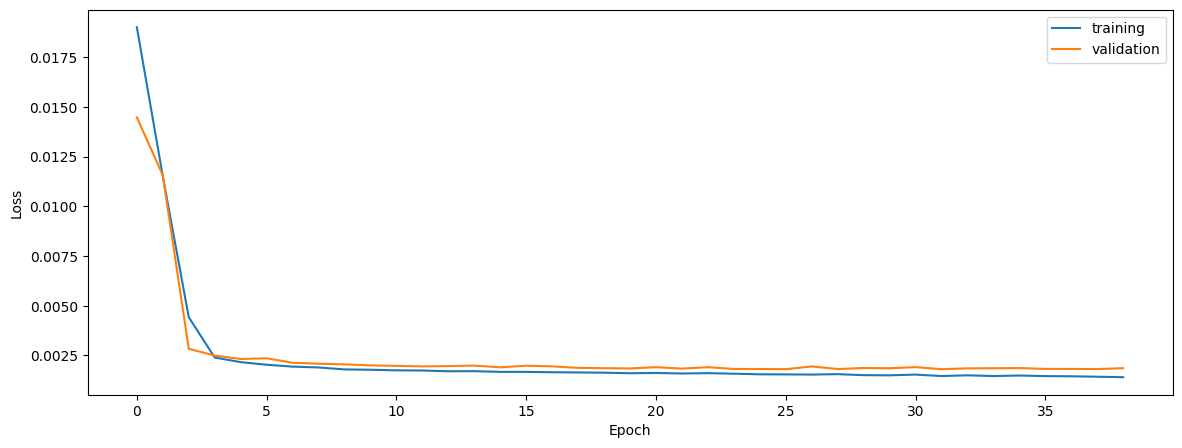

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9386643936872421
0.9359846610128711
0.9253100621512349


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9386643936872421
0.9359846610128711
0.9253100621512349


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9428695778950921
0.939626084001985
0.9355652321562398


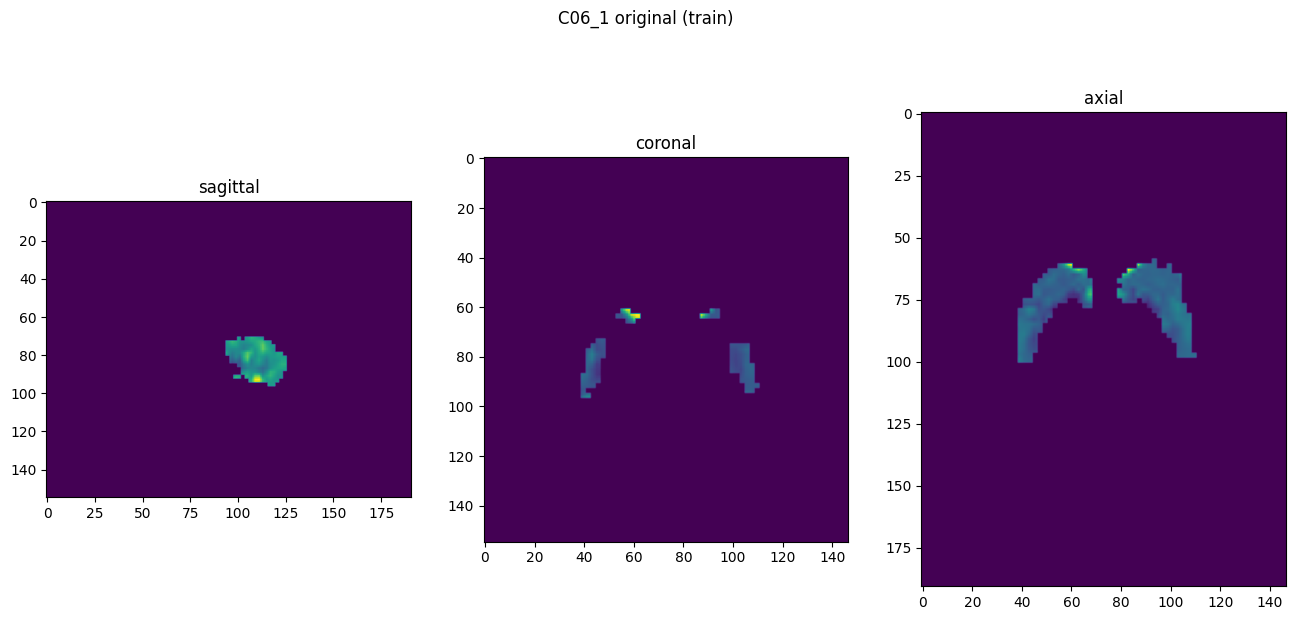

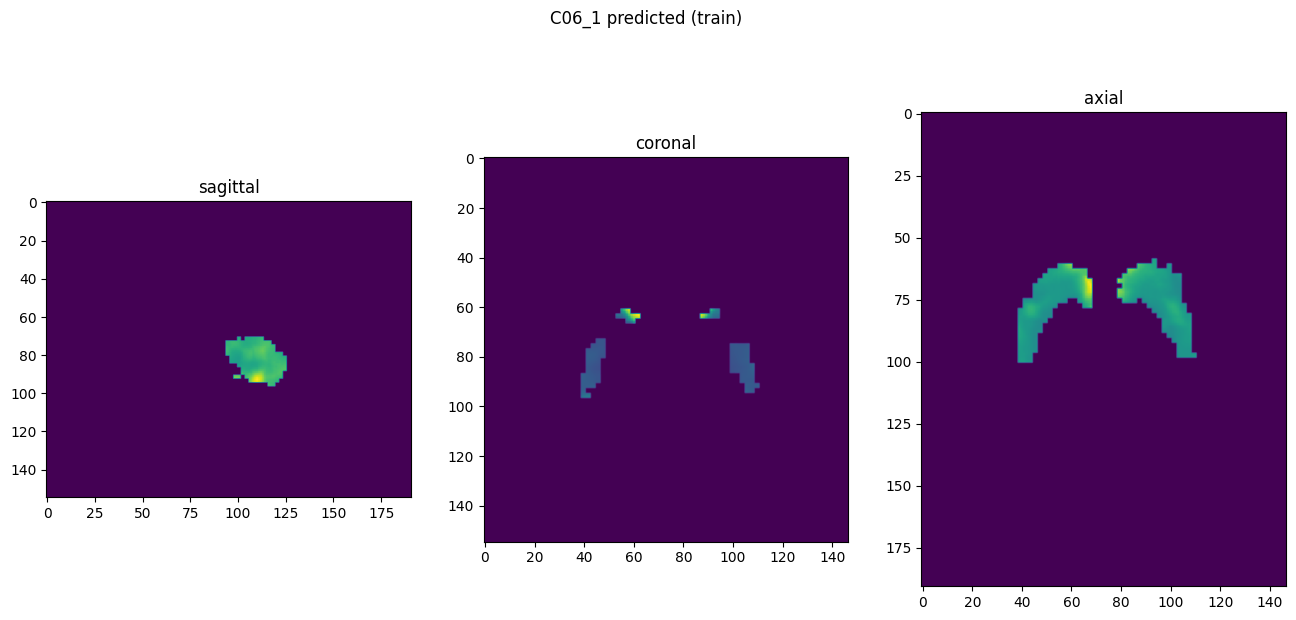

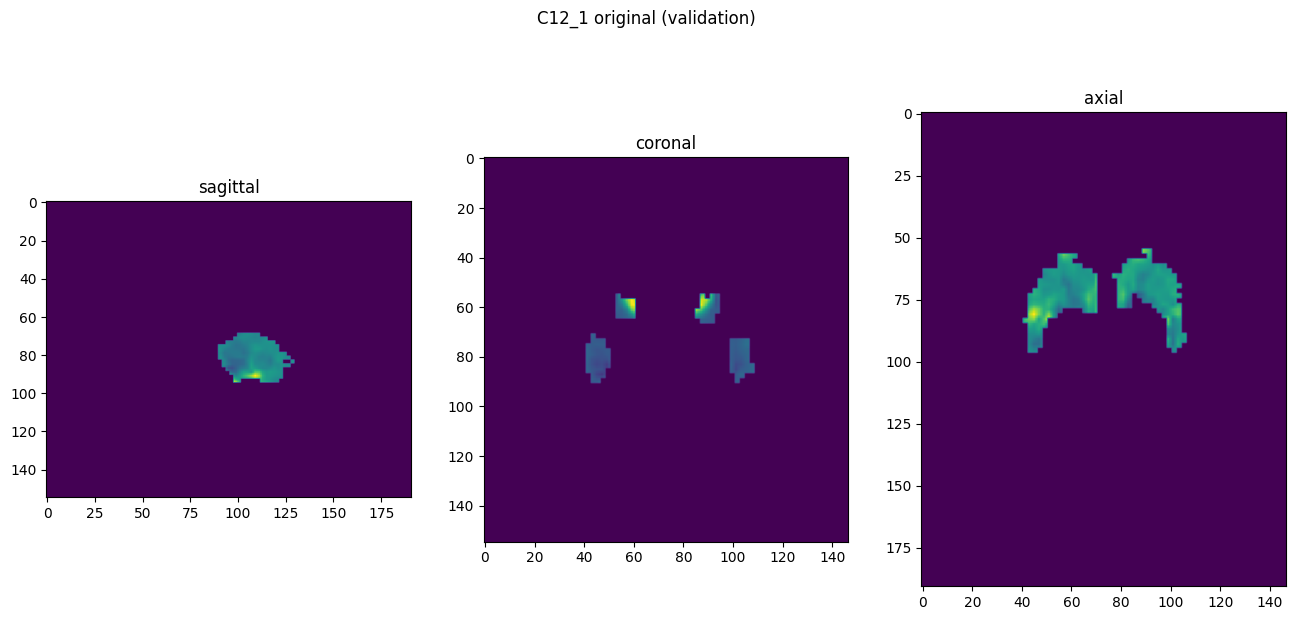

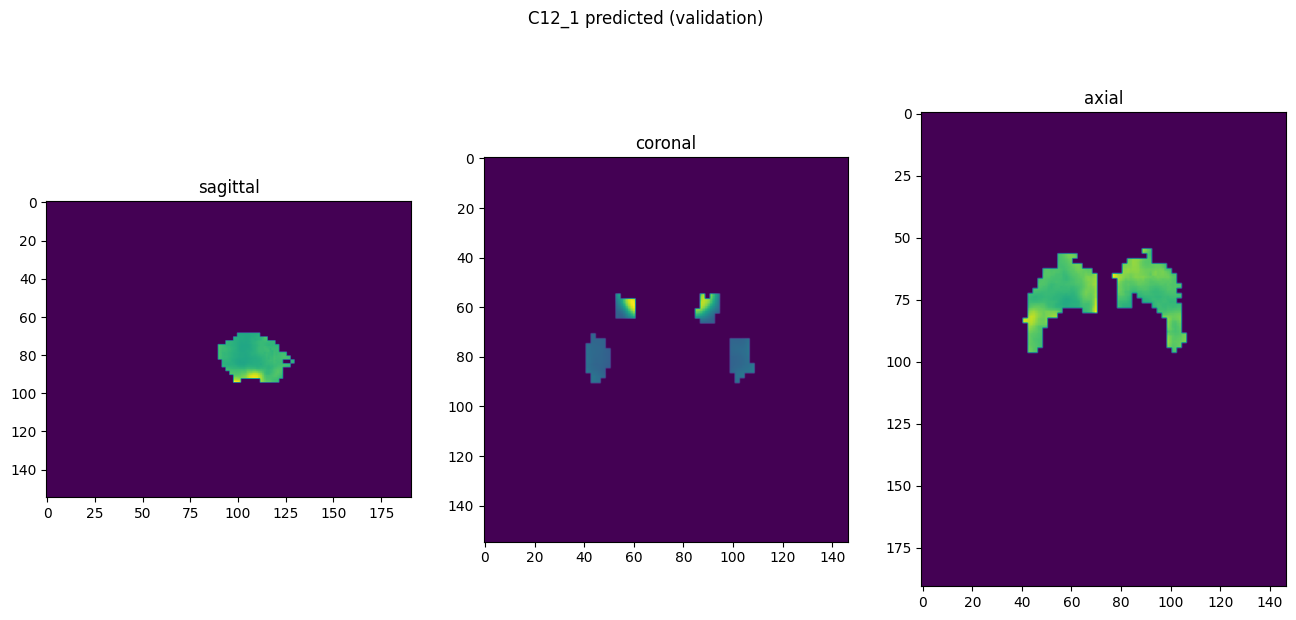

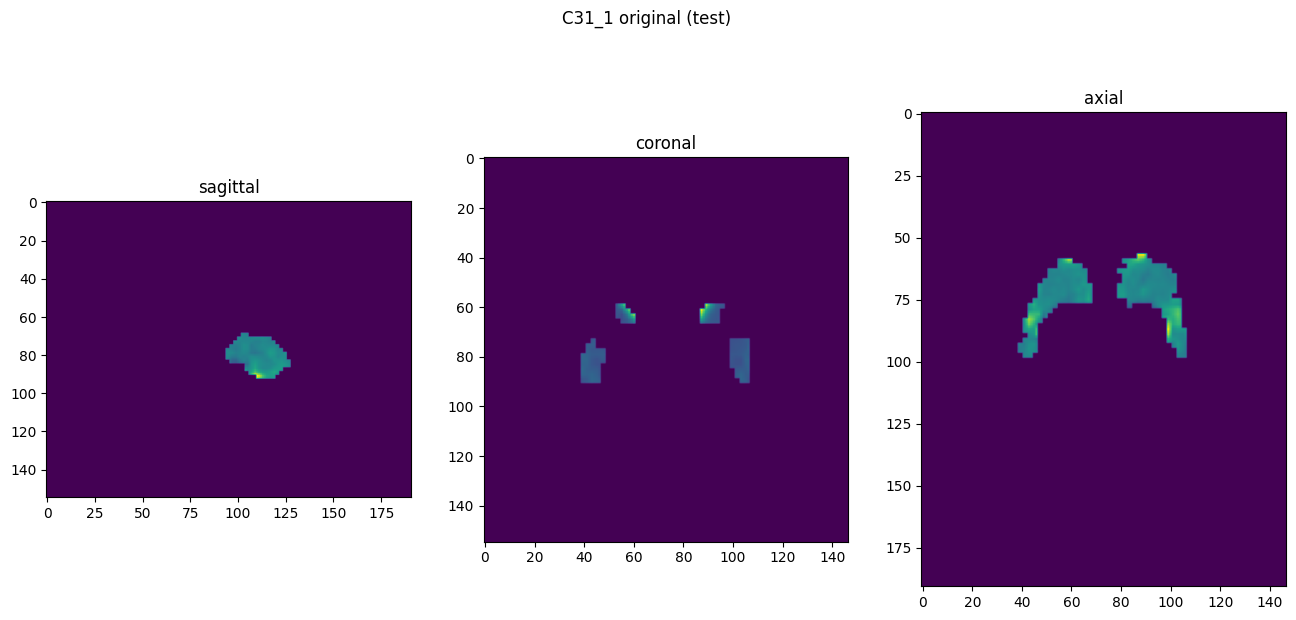

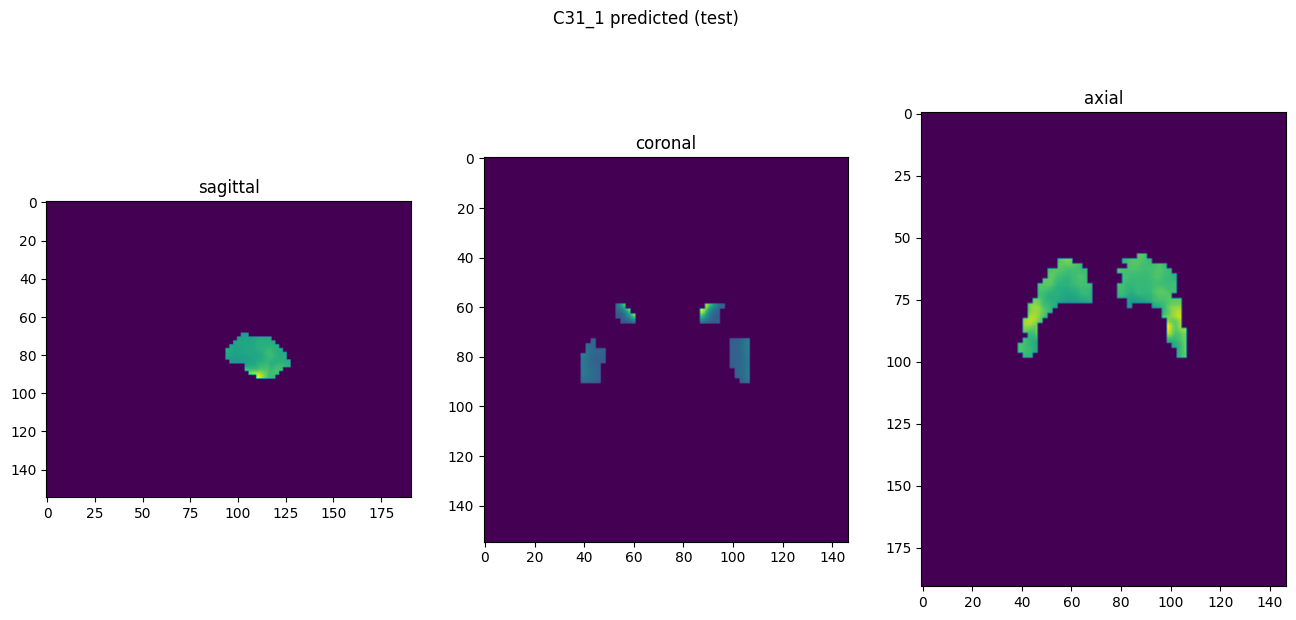

In [10]:
showResults(model, gen, threshold=None, background=False)